<a href="https://colab.research.google.com/github/Sirada99/CE888/blob/master/Lab9Exercise_1_VAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Make sure your GPU is connceted to RunTime. 

In [1]:
import keras
from keras import layers
from keras import backend as K
from keras.models import Model
import numpy as np

Using TensorFlow backend.


In [2]:
# Build the encoder

img_shape = (28, 28, 1)
batch_size = 16
latent_dim = 2 # Dimensionality of the latent space: a 2D plane
input_img = keras.Input(shape=img_shape)
x = layers.Conv2D(32, 3, padding='same', activation='relu')(input_img)
x = layers.Conv2D(64, 3, padding='same', activation='relu', strides=(2, 2))(x)
x = layers.Conv2D(64, 3, padding='same', activation='relu')(x)
x = layers.Conv2D(64, 3, padding='same', activation='relu')(x)
shape_before_flattening = K.int_shape(x)
x = layers.Flatten()(x)
x = layers.Dense(32, activation='relu')(x)

# The input image ends up being encoded into these two parameters
z_mean = layers.Dense(latent_dim)(x)
z_log_var = layers.Dense(latent_dim)(x)

Next is the code for using `z_mean` and `z_log_var`, the parameters of the statistical distribution assumed to have produced `input_img`, to generate a latent space point `z`. Here, you wrap some arbitrary code (built on top of Keras backend primitives) into a `Lambda` layer. In Keras, everything needs to be a layer, so code that isn’t part of a builtin layer should be wrapped in a `Lambda` (or in a custom layer).

In [3]:
# Latent-space-sampling function
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0., stddev=1.)
    return z_mean + K.exp(z_log_var) * epsilon

z = layers.Lambda(sampling)([z_mean, z_log_var])

### VAE decoder network, mapping latent space points to images

The following listing shows the decoder implementation. You reshape the vector `z `to the dimensions of an image and then use a few convolution layers to obtain a final image output that has the same dimensions as the original `input_img`.

In [0]:
decoder_input = layers.Input(K.int_shape(z)[1:]) # Input where you’ll feed z

x = layers.Dense(np.prod(shape_before_flattening[1:]), 
                 activation='relu')(decoder_input)
x = layers.Reshape(shape_before_flattening[1:])(x)
x = layers.Conv2DTranspose(32, 3,padding='same',
                           activation='relu',strides=(2, 2))(x)
x = layers.Conv2D(1, 3,padding='same',activation='sigmoid')(x)
decoder = Model(decoder_input, x)
z_decoded = decoder(z)

#### Custom layer used to compute the VAE loss

In [5]:
class CustomVariationalLayer(keras.layers.Layer):
    
    def vae_loss(self, x, z_decoded):
        x = K.flatten(x)
        z_decoded = K.flatten(z_decoded)
        xent_loss = keras.metrics.binary_crossentropy(x, z_decoded)
        kl_loss = -5e-4 * K.mean(
            1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
        return K.mean(xent_loss + kl_loss)
    
    #You implement custom layers You don't use by writing a call method.
    def call(self, inputs):
        x = inputs[0]
        z_decoded = inputs[1]
        loss = self.vae_loss(x, z_decoded)
        self.add_loss(loss, inputs=inputs)
        return x # You don't use this output, but the layer must return something.
    
y = CustomVariationalLayer()([input_img, z_decoded])


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


#### Training the VAE

In [6]:
from keras.datasets import mnist

vae = Model(input_img, y)
vae.compile(optimizer='rmsprop', loss=None)
vae.summary()

(x_train, _), (x_test, y_test) = mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_train = x_train.reshape(x_train.shape + (1,))
x_test = x_test.astype('float32') / 255.
x_test = x_test.reshape(x_test.shape + (1,))

vae.fit(x=x_train, y=None, shuffle=True, epochs=10, 
        batch_size=batch_size, validation_data=(x_test, None))


Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 28, 28, 32)   320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 14, 14, 64)   18496       conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 14, 14, 64)   36928       conv2d_2[0][0]                   
___________________________________________________________________________________________

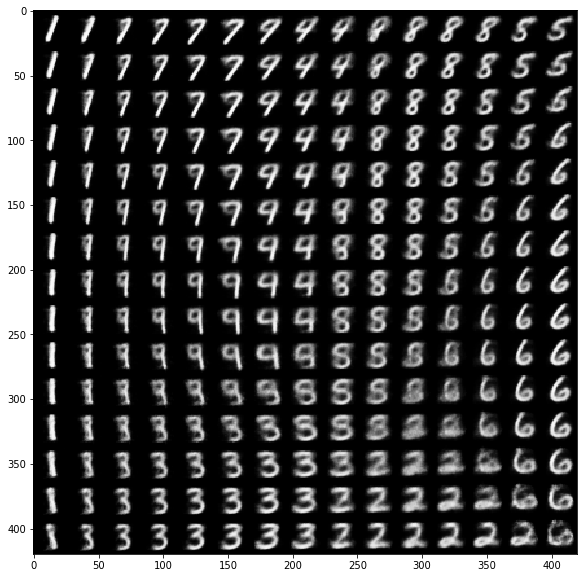

In [7]:
import matplotlib.pyplot as plt
from scipy.stats import norm
n = 15
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))
for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        z_sample = np.tile(z_sample, batch_size).reshape(batch_size, 2)
        x_decoded = decoder.predict(z_sample, batch_size=batch_size)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
            j * digit_size: (j + 1) * digit_size] = digit
        
plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='Greys_r')
plt.show()